<a href="https://colab.research.google.com/github/ACoolA-008/Data_Science_Projects/blob/main/Deep%20Learning%20Projects/C7.%20Siamese%20Neural%20Network/Implementing_a_Facial_Recognition_System_with_Siamese_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
faces_dir = "/content/drive/MyDrive/Kaggle/HaarCascade/att_faces/"

In [ ]:
# Cascade works by applying a series of simple to complex cascade Haar features
# on candidate regions of an image. The regions with most features passed is what
# we wanted to know. The corresponding feature as a classifer is known as a cascade classifier to
# detect faces.

face_cascades = cv2.CascadeClassifier("/content/drive/MyDrive/Kaggle/HaarCascade/haarcascade_frontalface_default.xml")

In [ ]:
def detect_faces(img, draw_box=True):
  """
  This function detects a face from an image and draws a box around the image.
  """
  grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_cascades.detectMultiScale(grayscale_img, scaleFactor=1.6)

  # draw bounding box around detected faces
  for (x,y,width,height) in faces:
    if draw_box:
      cv2.rectangle(img, (x,y), (x+width,y+height), (0,255,0), 5)
  face_box =img[y:y+height, x:x+width]
  face_coords = [x,y,width,height]
  return img,face_box,face_coords

In [ ]:
# Detect faces with cascades features

import os
files = os.listdir('/content/drive/MyDrive/Kaggle/HaarCascade/sample_faces')
images= [file for file in files if 'jpg' in file]
for image in images:
  img = cv2.imread("/content/drive/MyDrive/Kaggle/HaarCascade/sample_faces/" + image)
  detected_faces, _, _ = detect_faces(img)
  cv2.imwrite('/content/drive/MyDrive/Kaggle/HaarCascade/sample_faces/detected_faces/' + image, detected_faces)

Perform Face Recognition: \
Training neural networks for facial recognition tasks

In [ ]:
# Traverse all the subfolder within att_faces directory
# and load each image as a numpy array.

from keras.preprocessing.image import load_img, img_to_array


In [ ]:
# Store first 35 subjects as training set
# Store the remaining 5 subjects as test set

import numpy as np

X_train, y_train = [], []
X_test, y_test = [], []

subfolders = sorted([f.path for f in os.scandir(faces_dir) if f.is_dir()])

for idx, folder in enumerate(subfolders):
  for file in sorted(os.listdir(folder)):
    img = load_img(folder+"/"+file, color_mode='grayscale')
    img = img_to_array(img).astype('float32')/255
    if idx < 35:
      X_train.append(img)
      y_train.append(idx)
    else:
      X_test.append(img)
      y_test.append(idx-35)

In [ ]:
print(type(X_train))

<class 'list'>


In [ ]:
# Convert the lists into numpy array

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

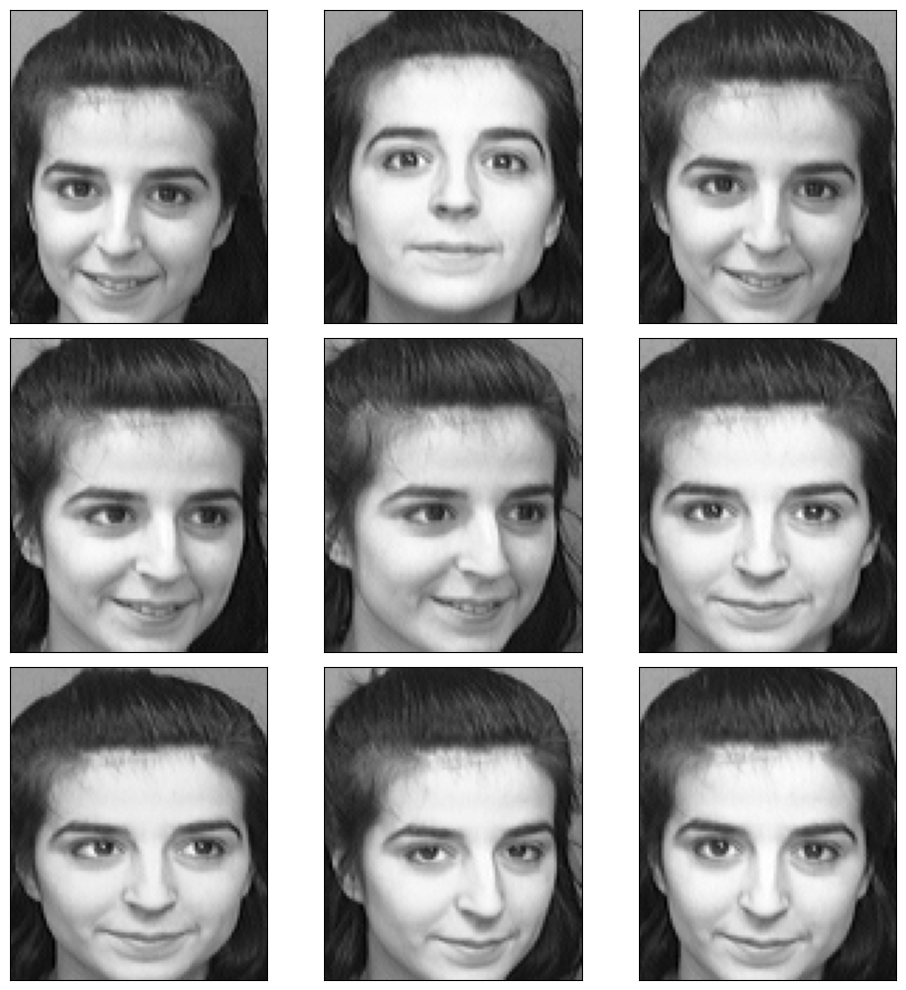

In [ ]:
# Plot some of the images

from matplotlib import pyplot as plt

subject_idx = 1

# create a 3 rows by 3 columns grid
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(10,10))

subject_img_idx = np.where(y_train==subject_idx)[0].tolist()

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
  img = X_train[subject_img_idx[i]]
  img = np.squeeze(img)
  ax.imshow(img, cmap='gray')
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])
plt.tight_layout()
plt.show()

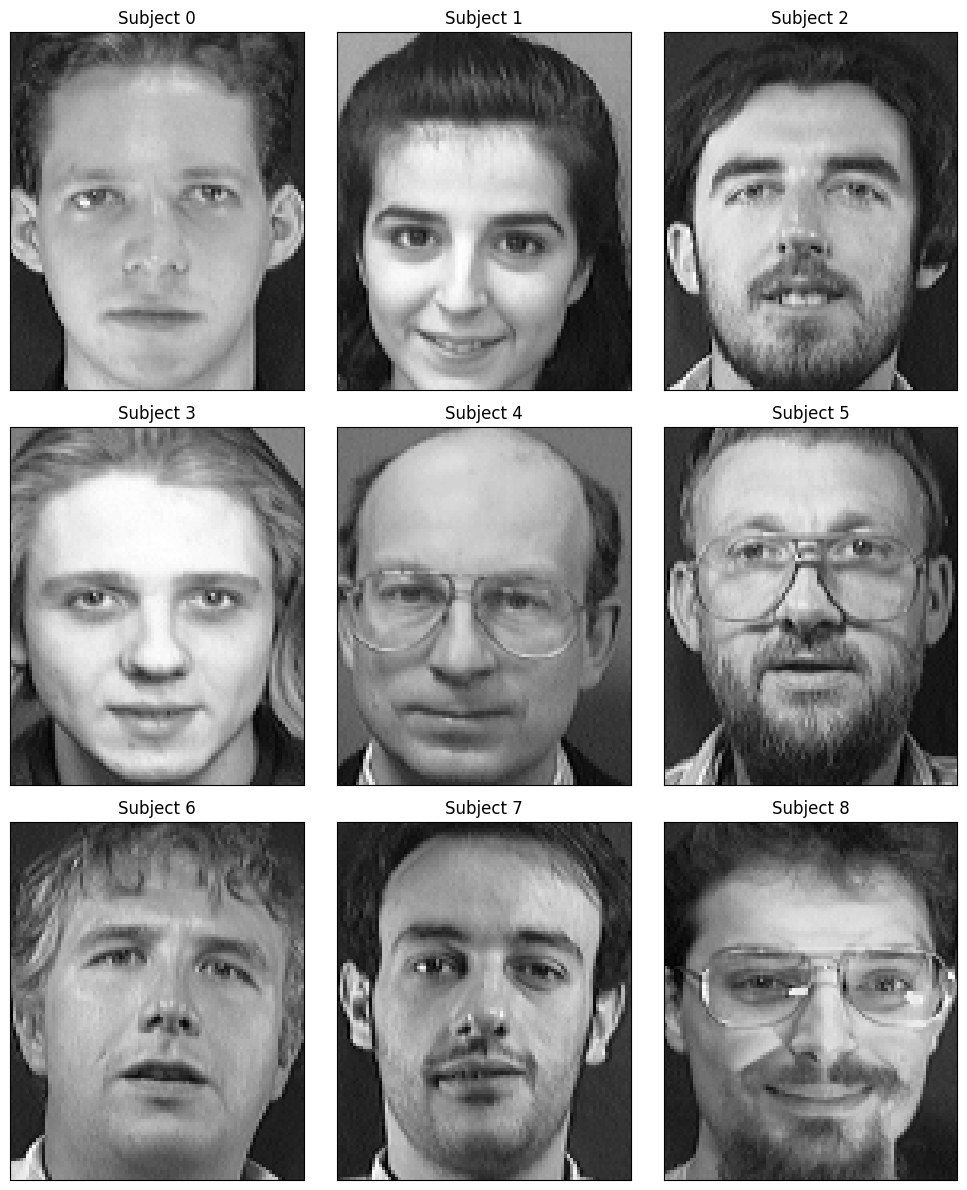

In [ ]:
# Plot 9 different images

subjects = range(10)

# create a 3 rows by 3 columns grid
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(10,12))

subject_img_idx = [np.where(y_train==i)[0].tolist()[0] for i in subjects]

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
  img = X_train[subject_img_idx[i]]
  img = np.squeeze(img)
  ax.imshow(img, cmap='gray')
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title("Subject {}".format(i))
plt.tight_layout()
plt.show()

Build a Siamese Neural Network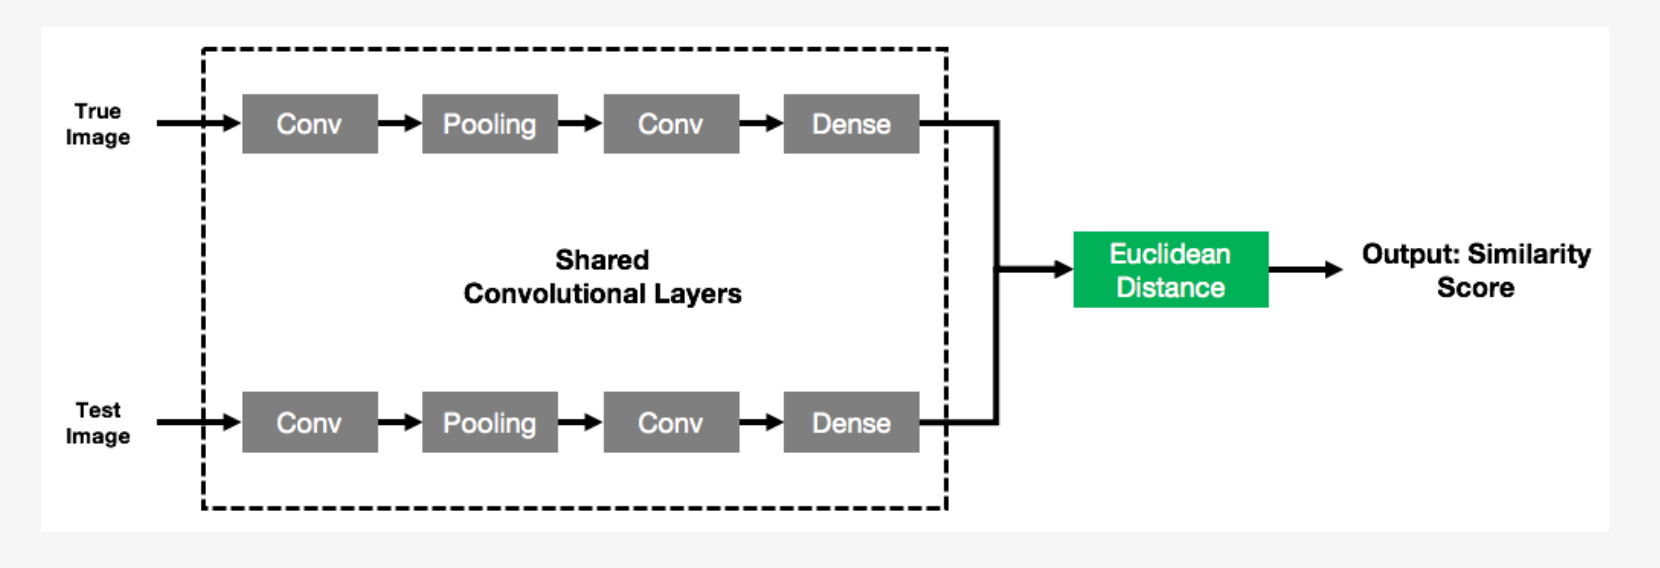


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Input
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

def create_shared_network(input_shape):
  model = Sequential()
  model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
  model.add(MaxPool2D())
  # 2 identical convolutional layers are built with the same weights
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
  model.add(Dense(units=128, activation='sigmoid'))
  return model

In [ ]:
# number of samples
# RGB color channels
X_train.shape

(350, 112, 92, 1)

In [ ]:
X_train.shape[1:]


(112, 92, 1)

In [ ]:
input_shape = X_train.shape[1:]
shared_network = create_shared_network(input_shape)

In [ ]:
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)

In [ ]:
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)

In [ ]:
print(output_top.shape)

(None, 53, 43, 128)


In [ ]:
# create a euclidean distance function
# note the top and bottom output combined results should be 128 x 1 dimensional vectors

from keras import backend as K
def euclidean_dist(vectors):
  vector1, vector2 = vectors
  sum_square = K.sum(K.square(vector1-vector2), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
from keras.layers import Lambda
distance = Lambda(euclidean_dist, output_shape=(1,))([output_top, output_bottom])

In [ ]:
from keras.models import Model
model = Model(inputs=[input_top, input_bottom], outputs=distance)

In [ ]:
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 112, 92, 1)]         0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 112, 92, 1)]         0         []                            
                                                                                                  
 sequential (Sequential)     (None, 53, 43, 128)          83392     ['input_11[0][0]',            
                                                                     'input_12[0][0]']            
                                                                                                  
 lambda_5 (Lambda)           (None, 1, 43, 128)           0         ['sequential[0][0]',    

In [ ]:
'''
Helper functions for face recognition
'''
import numpy as np
import random
import os
import cv2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(Y_true, D):
    margin = 1
    return K.mean(Y_true * K.square(D) + (1 - Y_true) * K.maximum((margin-D),0))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def create_pairs(X,Y, num_classes):
    pairs, labels = [], []
    # index of images in X and Y for each class
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # The minimum number of images across all classes
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1

    for c in range(num_classes):
        for n in range(min_images):
            # create positive pair
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1)

            # create negative pair
            # first, create list of classes that are different from the current class
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # select a random class from the negative list.
            # this class will be used to form the negative pair
            neg_c = random.sample(neg_list,1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1,img2))
            labels.append(0)

    return np.array(pairs), np.array(labels, dtype=np.float32) #np.array(data, dtype=np.float32)

def create_shared_network(input_shape):
    model = Sequential(name='Shared_Conv_Network')
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='sigmoid'))
    return model

def get_data(dir):
    X_train, Y_train = [], []
    X_test, Y_test = [], []
    subfolders = sorted([file.path for file in os.scandir(dir) if file.is_dir()])
    for idx, folder in enumerate(subfolders):
        for file in sorted(os.listdir(folder)):
            img = load_img(folder+"/"+file, color_mode='grayscale')
            img = img_to_array(img).astype('float32')/255
            img = img.reshape(img.shape[0], img.shape[1],1)
            if idx < 35:
                X_train.append(img)
                Y_train.append(idx)
            else:
                X_test.append(img)
                Y_test.append(idx-35)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)
    return (X_train, Y_train), (X_test, Y_test)



def write_on_frame(frame, text, text_x, text_y):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2)[0]
    box_coords = ((text_x, text_y), (text_x+text_width+20, text_y-text_height-20))
    cv2.rectangle(frame, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, text, (text_x, text_y-10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
    return frame

In [ ]:

import numpy as np
from keras.layers import Input, Lambda
from keras.models import Model

faces_dir = "/content/drive/MyDrive/Kaggle/HaarCascade/att_faces/"

# Import Training and Testing Data
(X_train, Y_train), (X_test, Y_test) = get_data(faces_dir)
num_classes = len(np.unique(Y_train))

# Create Siamese Neural Network
input_shape = X_train.shape[1:]
shared_network = create_shared_network(input_shape)
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)
distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])
model = Model(inputs=[input_top, input_bottom], outputs=distance)

# Train the model
training_pairs, training_labels = create_pairs(X_train, Y_train, num_classes=num_classes)
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])
# Convert labels to float32
# training_labels = training_labels.astype(np.float32)




In [ ]:
type(training_labels)

numpy.ndarray

In [ ]:
model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_labels,
          batch_size=128,
          epochs=10)

Epoch 1/10
5/5 [==============================] - 51s 9s/step - loss: 0.2812 - accuracy: 0.7361
Epoch 2/10
5/5 [==============================] - 37s 8s/step - loss: 0.1396 - accuracy: 0.8981
Epoch 3/10
5/5 [==============================] - 37s 7s/step - loss: 0.1189 - accuracy: 0.9104
Epoch 4/10
5/5 [==============================] - 38s 7s/step - loss: 0.1003 - accuracy: 0.9268
Epoch 5/10
5/5 [==============================] - 40s 8s/step - loss: 0.0883 - accuracy: 0.9381
Epoch 6/10
5/5 [==============================] - 37s 8s/step - loss: 0.0757 - accuracy: 0.9685
Epoch 7/10
5/5 [==============================] - 37s 7s/step - loss: 0.0615 - accuracy: 0.9713
Epoch 8/10
5/5 [==============================] - 39s 7s/step - loss: 0.0599 - accuracy: 0.9700
Epoch 9/10
5/5 [==============================] - 41s 8s/step - loss: 0.0630 - accuracy: 0.9694
Epoch 10/10
5/5 [==============================] - 37s 8s/step - loss: 0.0513 - accuracy: 0.9699


1/1 [==============================] - 1s 640ms/step


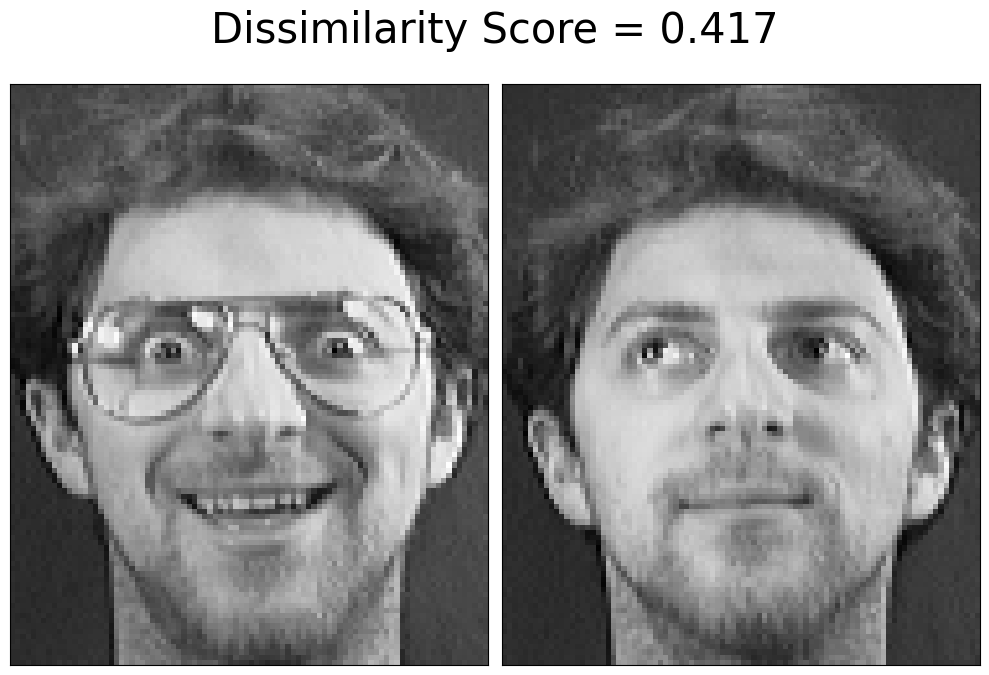

In [ ]:
import matplotlib.pyplot as plt


idx1, idx2 = 21, 29
img1 = np.expand_dims(X_test[idx1], axis=0)
img2 = np.expand_dims(X_test[idx2], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')

for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

dissimilarity = model.predict([img1, img2])[0][0]
fig.suptitle("Dissimilarity Score = {:.3f}".format(dissimilarity), size=30)
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 100ms/step


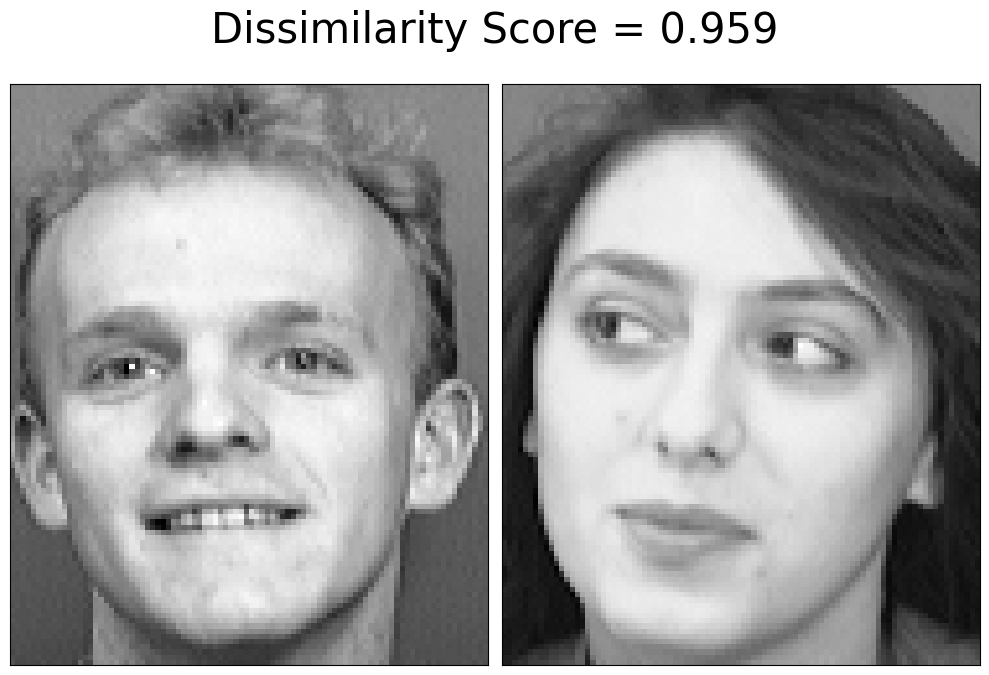

In [ ]:
idx1, idx2 = 1, 39
img1 = np.expand_dims(X_test[idx1], axis=0)
img2 = np.expand_dims(X_test[idx2], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')

for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

dissimilarity = model.predict([img1, img2])[0][0]
fig.suptitle("Dissimilarity Score = {:.3f}".format(dissimilarity), size=30)
plt.tight_layout()
plt.show()